### Mobility Prediction  Notebook



In [1]:
%%capture
# Install relevant libraries
!pip install geopandas folium

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm
import ast

import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import LineString
import folium

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)


## Loading and previewing data

In [4]:

# Load files
train = pd.read_csv('/Users/aarononosala/Downloads/Train (4).csv')
test = pd.read_csv('/Users/aarononosala/Downloads/Test (3).csv')
graph_df = pd.read_csv('/Users/aarononosala/Downloads/Graph.csv')
variable_def = pd.read_csv('/Users/aarononosala/Downloads/VariableDefinitions.csv')

# Preview Variable or columns definitions in the dataset
variable_def

Name  \
0           persistent_id   
1              count_norm   
2               speed_avg   
3        "first_weekday_"   
4     "first_weekday_00_"   
5   "first_weekday_00_0_"   
6   "first_weekday_00_1_"   
7   "first_weekday_00_2_"   
8   "first_weekday_00_3_"   
9     "first_weekday_01_"   
10  "first_weekday_01_0_"   
11                    ...   
12  "first_weekday_23_3_"   
13        "last_weekday_"   

                                                  Description  
0                                      id of the road section  
1                              normalized number of car trips  
2                           average speed (meters per second)  
3                                               First weekday  
4                                 first hour of the first day  
5            first quarter of the first hour of the first day  
6           second quarter of the first hour of the first day  
7            third quarter of the first hour of the first day  
8           fourth quarter of the first hour of the first day  
9                                second hour of the first day  
10          first quarter of the second hour of the first day  
11                                                        ...  
12  third quarter of the twenty-fourth hours of the first day  
13                                               Last weekday

In [5]:
# Preview train dataset
train.head()

ID  \
0  12176140421885990288_X_first_holiday_X_morning_rush_hour   
1    1822492832818209601_X_last_weekday_X_morning_rush_hour   
2    17257907785528223601_X_lbo_weekday_X_evening_rush_hour   
3   2650443045689789563_X_other_holiday_X_evening_rush_hour   
4    9545596265513284501_X_last_weekday_X_evening_rush_hour   

          persistent_id            day    prediction_type  count_norm_00_0_  \
0  12176140421885990288  first_holiday  morning_rush_hour           0.00001   
1   1822492832818209601   last_weekday  morning_rush_hour           0.00004   
2  17257907785528223601    lbo_weekday  evening_rush_hour               NaN   
3   2650443045689789563  other_holiday  evening_rush_hour               NaN   
4   9545596265513284501   last_weekday  evening_rush_hour               NaN   

   count_norm_00_1_  count_norm_00_2_  count_norm_00_3_  count_norm_01_0_  \
0               NaN           0.00004           0.00002           0.00013   
1           0.00007           0.00001           0.00003           0.00005   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   

   count_norm_01_1_  count_norm_01_2_  count_norm_01_3_  count_norm_02_0_  \
0           0.00000               NaN           0.00005           0.00007   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   

   count_norm_02_1_  count_norm_02_2_  count_norm_02_3_  count_norm_03_0_  \
0           0.00004               NaN           0.00005           0.00006   
1               NaN           0.00004           0.00006           0.00002   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   

   count_norm_03_1_  count_norm_03_2_  count_norm_03_3_  count_norm_04_0_  \
0           0.00003               NaN           0.00003           0.00001   
1               NaN           0.00000               NaN           0.00000   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   

   count_norm_04_1_  count_norm_04_2_  count_norm_04_3_  count_norm_05_0_  \
0           0.00004           0.00002           0.00002           0.00013   
1           0.00006           0.00005           0.00014           0.00001   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   

   count_norm_05_1_  count_norm_07_2_  count_norm_07_3_  count_norm_08_0_  \
0           0.00007               NaN               NaN               NaN   
1           0.00009               NaN               NaN               NaN   
2               NaN           0.00009           0.00001               NaN   
3               NaN           0.00013           0.00004           0.00014   
4               NaN           0.00013           0.00014           0.00018   

   count_norm_08_1_  count_norm_08_2_  count_norm_08_3_  count_norm_09_0_  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2               NaN           0.00005               NaN           0.00004   
3           0.00015           0.00018           0.00017           0.00033   
4           0.00023           0.00030   

In [6]:
# Preview test dataset
test.head()

ID  \
0     5805365396938277294_X_lbo_weekday_X_morning_rush_hour   
1  6383912664733604267_X_second_weekday_X_evening_rush_hour   
2   9685043778615900869_X_other_holiday_X_evening_rush_hour   
3   13385092549461410612_X_last_weekday_X_morning_rush_hour   
4   5760726675439177299_X_other_weekday_X_evening_rush_hour   

          persistent_id             day    prediction_type  count_norm_00_0_  \
0   5805365396938277294     lbo_weekday  morning_rush_hour           0.00022   
1   6383912664733604267  second_weekday  evening_rush_hour               NaN   
2   9685043778615900869   other_holiday  evening_rush_hour               NaN   
3  13385092549461410612    last_weekday  morning_rush_hour           0.00050   
4   5760726675439177299   other_weekday  evening_rush_hour               NaN   

   count_norm_00_1_  count_norm_00_2_  count_norm_00_3_  count_norm_01_0_  \
0           0.00037           0.00045           0.00018           0.00015   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3           0.00031           0.00021           0.00023           0.00015   
4               NaN               NaN               NaN               NaN   

   count_norm_01_1_  count_norm_01_2_  count_norm_01_3_  count_norm_02_0_  \
0           0.00010           0.00007           0.00008           0.00019   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3           0.00015           0.00025           0.00016           0.00016   
4               NaN               NaN               NaN               NaN   

   count_norm_02_1_  count_norm_02_2_  count_norm_02_3_  count_norm_03_0_  \
0           0.00016           0.00008           0.00015           0.00014   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3           0.00004           0.00012           0.00008           0.00008   
4               NaN               NaN               NaN               NaN   

   count_norm_03_1_  count_norm_03_2_  count_norm_03_3_  count_norm_04_0_  \
0           0.00002           0.00010           0.00016           0.00018   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3           0.00019           0.00010           0.00009           0.00001   
4               NaN               NaN               NaN               NaN   

   count_norm_04_1_  count_norm_04_2_  count_norm_04_3_  count_norm_05_0_  \
0           0.00013           0.00007           0.00013           0.00016   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3           0.00018           0.00015           0.00018           0.00011   
4               NaN               NaN               NaN               NaN   

   count_norm_05_1_  count_norm_07_2_  count_norm_07_3_  count_norm_08_0_  \
0           0.00028               NaN               NaN               NaN   
1               NaN           0.00052           0.00054           0.00056   
2               NaN           0.00015           0.00003           0.00009   
3           0.00019               NaN               NaN               NaN   
4               NaN           0.00008               NaN           0.00005   

   count_norm_08_1_  count_norm_08_2_  count_norm_08_3_  count_norm_09_0_  \
0               NaN               NaN               NaN               NaN   
1           0.00083           0.00043           0.00063           0.00046   
2           0.00016           0.00015           0.00030           0.00028   
3               NaN               NaN               NaN               NaN   
4           0.00004           0.00

In [7]:
# Preview graph data
graph_df.head()

can_bind_to_reverse_edge  category country_isocode  edge_type  \
0                     False         3              CD  NamedRoad   
1                     False         3              CD  NamedRoad   
2                     False         3              CD  NamedRoad   
3                     False         2              CD  NamedRoad   
4                     False         2              CD  NamedRoad   

   ends_with_crosswalk  ends_with_railroad_crossing  ends_with_toll_post  \
0                False                        False                False   
1                False                        False                False   
2                False                        False                False   
3                False                        False                False   
4                False                        False                False   

   ends_with_traffic_light  \
0                    False   
1                    False   
2                    False   
3                    False   
4                    False   

                                                                                                                                       geometry  \
0                         [[15.352717;-4.382694;];[15.352853;-4.383144;];[15.352953;-4.383406;];[15.353126;-4.383739;];[15.353242;-4.383897;];]   
1                                                                                              [[15.352661;-4.382339;];[15.352717;-4.382694;];]   
2                                                                       [[15.352601;-4.381799;];[15.352630;-4.382133;];[15.352661;-4.382339;];]   
3  [[15.347741;-4.376426;];[15.347670;-4.376250;];[15.347537;-4.375942;];[15.347327;-4.375540;];[15.346976;-4.374841;];[15.346415;-4.373764;];]   
4                                                                                              [[15.347903;-4.376944;];[15.347741;-4.376426;];]   

   has_masstransit_lane  is_in_poor_condition  is_paved  is_residential  \
0                 False                 False      True           False   
1                 False                 False      True           False   
2                 False                 False      True           False   
3                 False                 False      True           False   
4                 False                 False      True           False   

   is_restricted_for_trucks  is_toll    length         persistent_id  \
0                     False    False 146.30000   7823179214164718408   
1                     False    False  39.70000  18394085582372647230   
2                     False    False  60.10000  11612760148096368926   
3                     False    False 329.20001   5924644812396770912   
4                     False    False  60.00000  13617569950093686421   

  reverse_id  segments  speed_limit struct_type         timezone      toponym  \
0                    4          NaN        Road  Africa/Kinshasa  Poids Lourd   
1                    1          NaN        Road  Africa/Kinshasa  Poids Lourd   
2                    2          NaN        Road  Africa/Kinshasa  Poids Lourd   
3                    5          NaN        Road  Africa/Kinshasa          NaN   
4                    1          NaN        Road  Africa/Kinshasa          NaN   

   traffic_side  
0         False  
1         False  
2         False  
3         False  
4         False

In [8]:
# Check size and shape of datasets
train.shape, test.shape

((26157, 165), (11322, 164))

In [9]:
# Train to test sets split
(test.shape[0]) / (train.shape[0] + test.shape[0])

0.3020891699351637


## Statistical summaries

In [10]:
# Train statistical summary
train.describe(include = 'all')

ID  \
count                                                      26157   
unique                                                     26157   
top     12176140421885990288_X_first_holiday_X_morning_rush_hour   
freq                                                           1   
mean                                                         NaN   
std                                                          NaN   
min                                                          NaN   
25%                                                          NaN   
50%                                                          NaN   
75%                                                          NaN   
max                                                          NaN   

                    persistent_id            day    prediction_type  \
count                 26157.00000          26157              26157   
unique                        NaN              7                  2   
top                           NaN  first_holiday  evening_rush_hour   
freq                          NaN           3771              13127   
mean    9085154866126743552.00000            NaN                NaN   
std     5337437672986984448.00000            NaN                NaN   
min       14490472028725208.00000            NaN                NaN   
25%     4486075934233592320.00000            NaN                NaN   
50%     8860323198940037120.00000            NaN                NaN   
75%    13653709219825786880.00000            NaN                NaN   
max    18446482090816438272.00000            NaN                NaN   

        count_norm_00_0_  count_norm_00_1_  count_norm_00_2_  \
count        10764.00000       10715.00000       10341.00000   
unique               NaN               NaN               NaN   
top                  NaN               NaN               NaN   
freq                 NaN               NaN               NaN   
mean             0.00015           0.00014           0.00013   
std              0.00019           0.00018           0.00016   
min              0.00000           0.00000           0.00000   
25%              0.00004           0.00005           0.00004   
50%              0.00009           0.00008           0.00007   
75%              0.00016           0.00016           0.00014   
max              0.00163           0.00158           0.00134   

        count_norm_00_3_  count_norm_01_0_  count_norm_01_1_  \
count         9431.00000        9512.00000        8999.00000   
unique               NaN               NaN               NaN   
top                  NaN               NaN               NaN   
freq                 NaN               NaN               NaN   
mean             0.00012           0.00012           0.00011   
std              0.00015           0.00014           0.00014   
min              0.00000           0.00000           0.00000   
25%              0.00004           0.00004           0.00004   
50%              0.00007           0.00007           0.00007   
75%              0.00015           0.00014           0.00013   
max              0.00126           0.00101           0.00129   

        count_norm_01_2_  count_norm_01_3_  count_norm_02_0_  \
count         8549.00000        8017.00000        8018.00000   
unique               NaN               NaN               NaN   
top                  NaN               NaN               NaN   
freq                 NaN               NaN               NaN   
mean             0.00010           0.00010           0.00009   
std              0.00012           0.00011           0.00010   
min              0.00000           0.00000           0.00000   
25%              0.00003           0.00003           0.00003   
50%              0.00006           0.00006           0.00006   
75%              0.00012           0.00011           0.00011   
max              0.00090           0.00087           0.00077   

        count_norm_02_1_  count_norm_02_2_  count_norm_02_3_  \
count         7974.00

From the above statistical summary, we can deduce some of the following insights:
 - The train data provided has 26157 data points
 - There are 7 unique days in the dataset
 - There are a lot of missing values
 - The maximum target/speed is 21.54280

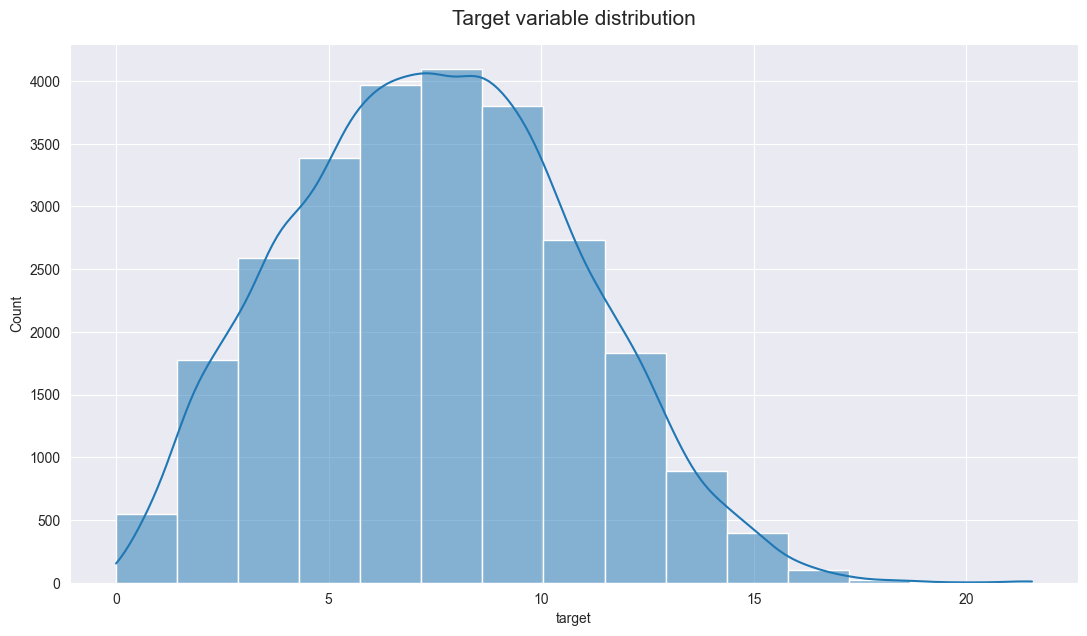

None

0.17021072875601495

In [11]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.target, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.target.skew())

The target variable is appears to be normally distributed but has a skew of ~0.17




## Outliers


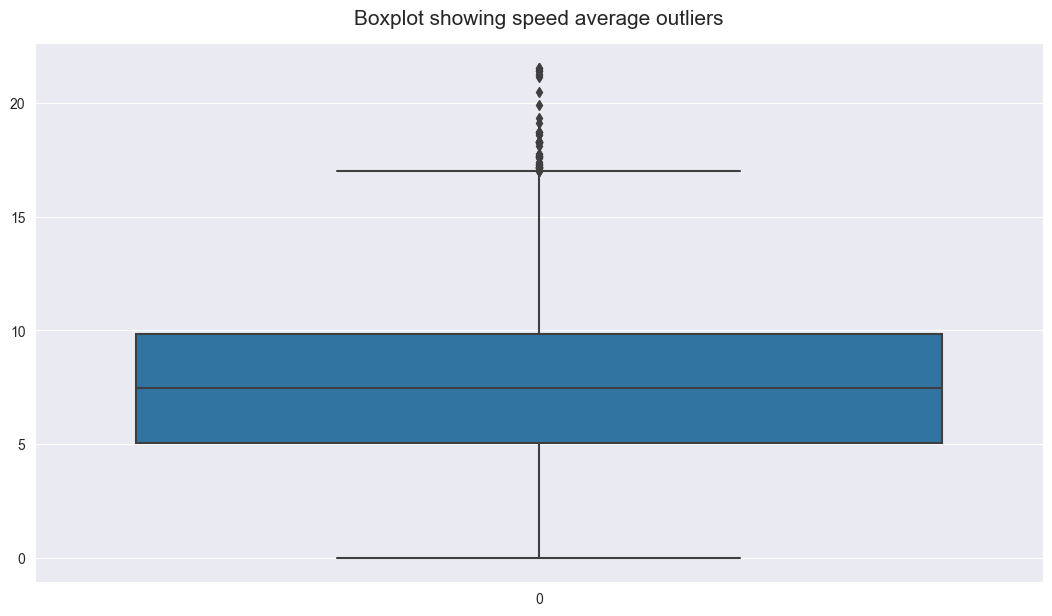

In [12]:
# Plotting boxplot for speed average
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.target)
plt.title('Boxplot showing speed average outliers', y = 1.02, fontsize = 15)
plt.show()

Outliers are those data points which differ significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...



## Roads Visualisation

In [13]:
# Create a geopandas df
# convert the geometry column to a tuple
graph_df.geometry = graph_df.geometry.apply(lambda x: ast.literal_eval(x.replace(';', ',').replace('[', '(').replace(']', ')')))

# Create LineString objects from the tuples of coordinates
lines = [LineString(coords) for coords in graph_df['geometry']]

# Create a GeoDataFrame with LineString geometry
gdf = gpd.GeoDataFrame(graph_df, geometry=lines)

# Preview
gdf.head(2)

can_bind_to_reverse_edge  category country_isocode  edge_type  \
0                     False         3              CD  NamedRoad   
1                     False         3              CD  NamedRoad   

   ends_with_crosswalk  ends_with_railroad_crossing  ends_with_toll_post  \
0                False                        False                False   
1                False                        False                False   

   ends_with_traffic_light  \
0                    False   
1                    False   

                                                                                                     geometry  \
0  LINESTRING (15.35272 -4.38269, 15.35285 -4.38314, 15.35295 -4.38341, 15.35313 -4.38374, 15.35324 -4.38390)   
1                                                           LINESTRING (15.35266 -4.38234, 15.35272 -4.38269)   

   has_masstransit_lane  is_in_poor_condition  is_paved  is_residential  \
0                 False                 False      True           False   
1                 False                 False      True           False   

   is_restricted_for_trucks  is_toll    length         persistent_id  \
0                     False    False 146.30000   7823179214164718408   
1                     False    False  39.70000  18394085582372647230   

  reverse_id  segments  speed_limit struct_type         timezone      toponym  \
0                    4          NaN        Road  Africa/Kinshasa  Poids Lourd   
1                    1          NaN        Road  Africa/Kinshasa  Poids Lourd   

   traffic_side  
0         False  
1         False

### Visualise all the road sections in the provided dataset

In [14]:
# Create a Folium map centered at a specific location
map_center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]
mymap = folium.Map(location=map_center, zoom_start=12)

# Iterate through the GeoDataFrame and add LineString objects to the map
for idx, row in gdf.iterrows():
    folium.GeoJson(row['geometry']).add_to(mymap)

# Display the map
mymap

### Visualise road sections in training and test datasets

In [15]:
train_copy = train[['persistent_id', 'target']]
train_copy ['dataset'] = 'train'
test_copy = test[['persistent_id']]
test_copy ['dataset'] = 'test'
train_test = pd.concat([train_copy, test_copy])
new_gdf = gdf.merge(train_test[['persistent_id', 'target', 'dataset']], how = 'left', on = ['persistent_id'])
new_gdf.head(2)

can_bind_to_reverse_edge  category country_isocode  edge_type  \
0                     False         3              CD  NamedRoad   
1                     False         3              CD  NamedRoad   

   ends_with_crosswalk  ends_with_railroad_crossing  ends_with_toll_post  \
0                False                        False                False   
1                False                        False                False   

   ends_with_traffic_light  \
0                    False   
1                    False   

                                                                                                     geometry  \
0  LINESTRING (15.35272 -4.38269, 15.35285 -4.38314, 15.35295 -4.38341, 15.35313 -4.38374, 15.35324 -4.38390)   
1  LINESTRING (15.35272 -4.38269, 15.35285 -4.38314, 15.35295 -4.38341, 15.35313 -4.38374, 15.35324 -4.38390)   

   has_masstransit_lane  is_in_poor_condition  is_paved  is_residential  \
0                 False                 False      True           False   
1                 False                 False      True           False   

   is_restricted_for_trucks  is_toll    length        persistent_id  \
0                     False    False 146.30000  7823179214164718408   
1                     False    False 146.30000  7823179214164718408   

  reverse_id  segments  speed_limit struct_type         timezone      toponym  \
0                    4          NaN        Road  Africa/Kinshasa  Poids Lourd   
1                    4          NaN        Road  Africa/Kinshasa  Poids Lourd   

   traffic_side  target dataset  
0         False 5.82557   train  
1         False 8.19028   train

In [16]:
# Preview roads in train
new_gdf.toponym.value_counts(normalize = True)

toponym
Avenue de la Libération               0.19272
Avenue By Pass                        0.15223
Avenue Kasa-Vubu                      0.14981
Boulevard Lumumba                     0.12789
Chaussée Mzee Laurent-Désiré Kabila   0.09970
Route de Matadi                       0.07008
Boulevard du 30 Juin                  0.05530
Avenue Nguma                          0.05438
Avenue Colonel Mondjiba               0.02453
Avenue Sendwe                         0.01427
Boulevard Triomphal                   0.01338
Poids Lourd                           0.00758
Avenue Tourisme                       0.00624
Avenue de la montagne                 0.00414
Saut-de-Mouton                        0.00401
Place de la Gare                      0.00401
Avenue des Sénégalais                 0.00312
Avenue Kase Vubu                      0.00312
Pont Matete                           0.00268
Avenue d'Isiro                        0.00268
Pont Makelele                         0.00268
Avenue Sefu               

In [17]:
# Visualise Avenue_Sefu
sefu = new_gdf[new_gdf.toponym == 'Avenue Sefu']

# Create a Folium map centered at a specific location
map_center = [sefu.geometry.centroid.y.mean(), sefu.geometry.centroid.x.mean()]
mymap = folium.Map(location=map_center, zoom_start=20)

# Iterate through the GeoDataFrame and add LineString objects to the map
for idx, row in sefu.iterrows():
    folium.GeoJson(row['geometry'], style_function=lambda feature: {'weight': 5}).add_to(mymap)

# Display the map
mymap

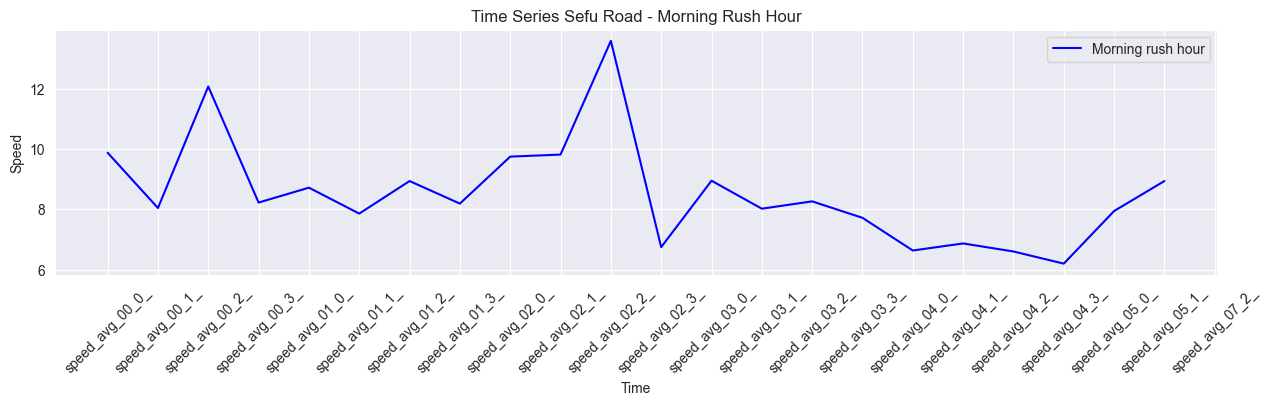

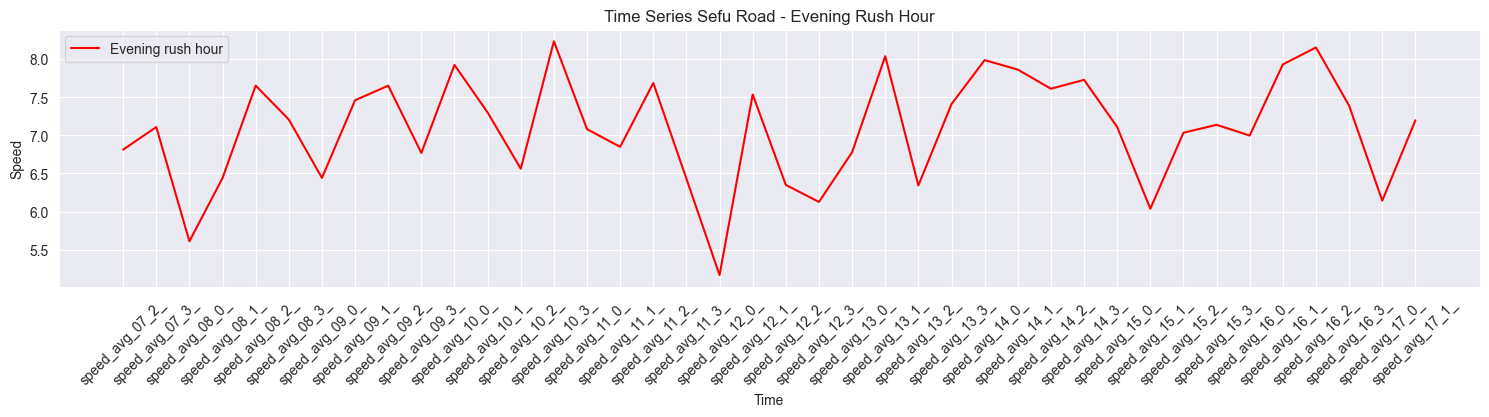

In [18]:
train_graph = train.merge(graph_df, how = 'left', on = 'persistent_id')
sefu_ave = train_graph[train_graph.toponym == 'Avenue Sefu']

sefu = sefu_ave[sefu_ave.day == 'second_weekday'][[x for x in sefu_ave.columns if x.startswith('speed_avg')]].T.reset_index().iloc[:, :3]
sefu.columns = ['time', 'morning_rush', 'evening_rush']

plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.plot(sefu['time'], sefu['morning_rush'], color='blue', label='Morning rush hour')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Time Series Sefu Road - Morning Rush Hour')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 2)
plt.plot(sefu.iloc[22:62, :]['time'], sefu.iloc[22:62, :]['evening_rush'], color='red', label='Evening rush hour')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Time Series Sefu Road - Evening Rush Hour')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()

# Show the plot
plt.show()


## Missing values and duplicates

In [19]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any()

(True, True)

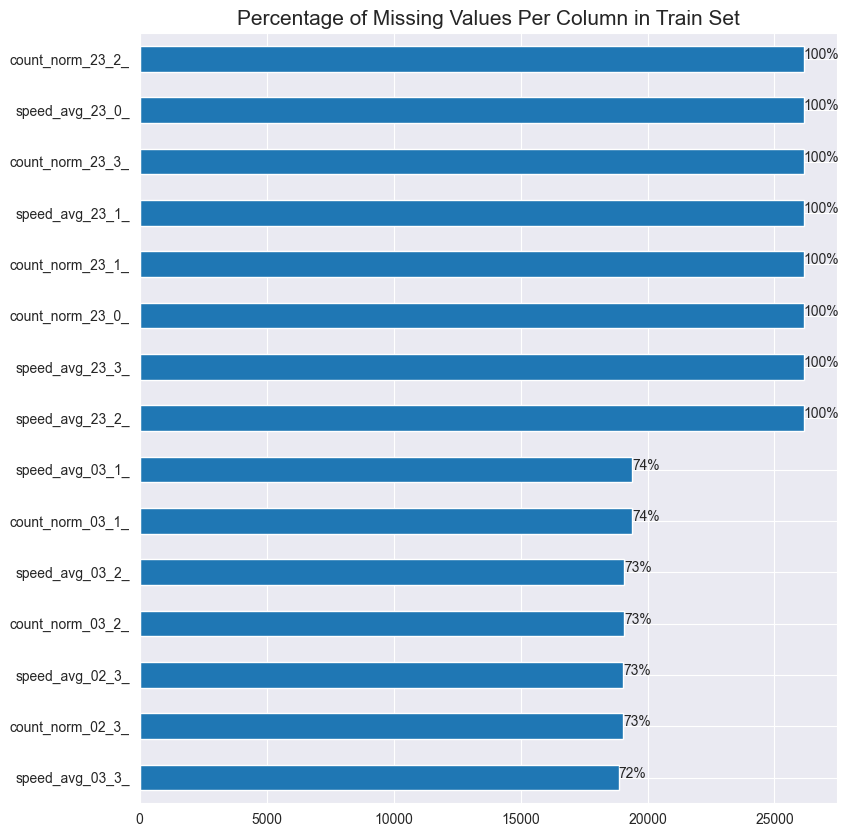

In [20]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Insights:
 - Most of the times there were no cars at midnight

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

In [21]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)


## Correlations

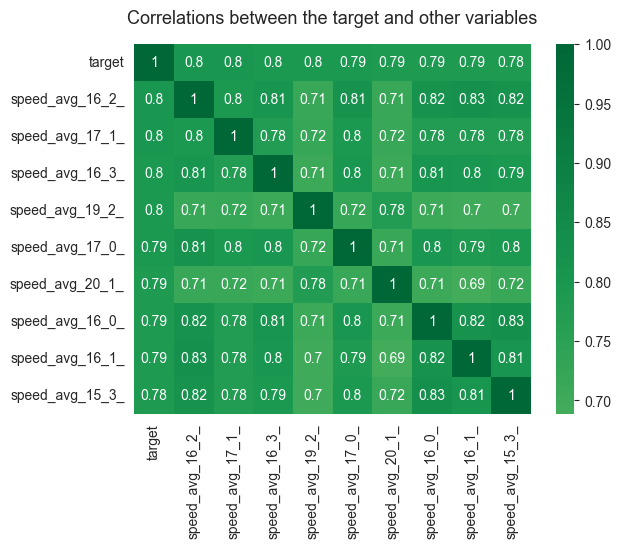

In [22]:
# Select numerical features from the training dataset
train_num_df = train.select_dtypes(include=['number'])

# Compute the absolute correlations of numerical features with 'target'
top10_corrs = abs(train_num_df.corr()['target']).sort_values(ascending=False).head(10)

# Compute the correlation matrix for the top 10 features
corr = train_num_df[list(top10_corrs.index)].corr()

# Plot a heatmap of the correlation matrix
# The heatmap visualizes the correlations between 'target' and other top features
# 'RdYlGn' colormap is used with annotations and centered at 0 for better clarity
sns.heatmap(corr, cmap='RdYlGn', annot=True, center=0)
plt.title('Correlations between the target and other variables', pad=15, fontdict={'size': 13})
plt.show()



## Modelling

In [23]:
# Selecting the independent variables and the target variable

X = train.drop(['ID', 'persistent_id', 'day', 'prediction_type', 'target'], axis = 1).fillna(0)
y = train.target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

# Instantiating the model
reg = RandomForestRegressor(random_state = SEED, n_jobs=-1)
reg.fit(X_train, y_train)

# Making predictions
y_pred = reg.predict(X_test)

# Measuring the accuracy of the model
print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}') # 1.5748725596742121

RMSE Score: 1.5760960707073775


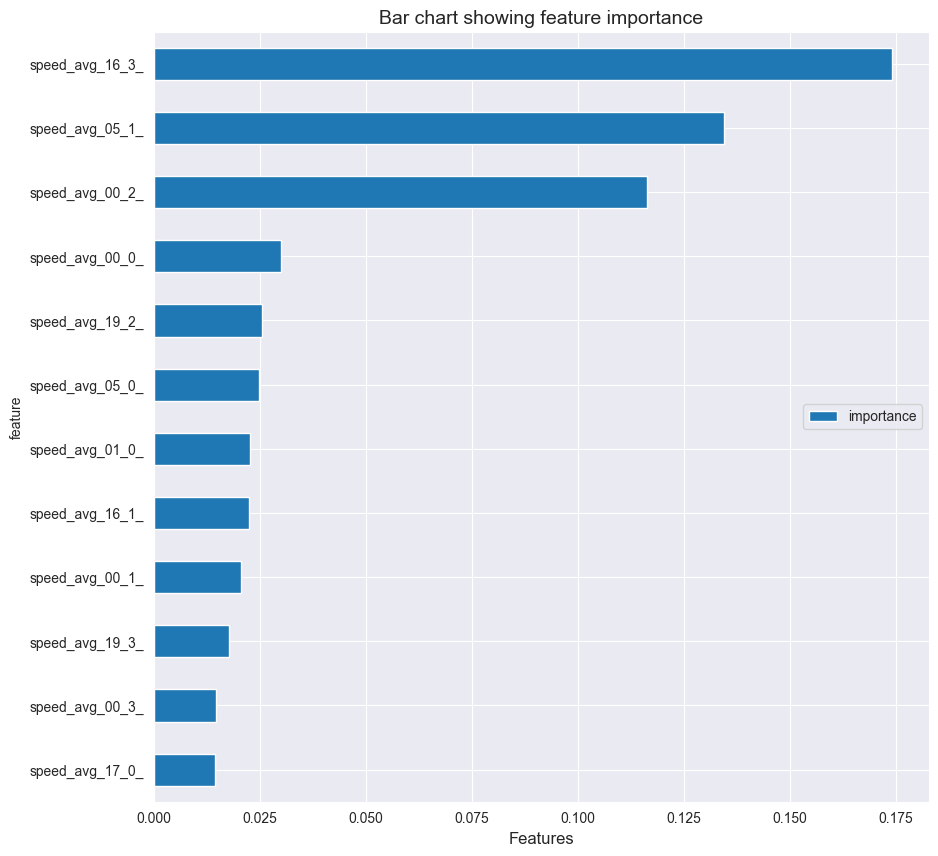

In [24]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': reg.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()


## Making predictions of the test set and creating a submission file

In [25]:
# Make prediction on the test set
test_df = test.drop(['ID', 'persistent_id', 'day', 'prediction_type'], axis = 1).fillna(0)
predictions = reg.predict(test_df)

# # Create a submission file
sub_file = pd.DataFrame({'ID': test.ID, 'target': predictions})
sub_file.head()

ID   target
0     5805365396938277294_X_lbo_weekday_X_morning_rush_hour  6.52412
1  6383912664733604267_X_second_weekday_X_evening_rush_hour  9.65362
2   9685043778615900869_X_other_holiday_X_evening_rush_hour 10.44068
3   13385092549461410612_X_last_weekday_X_morning_rush_hour 12.79979
4   5760726675439177299_X_other_weekday_X_evening_rush_hour  5.63904

# FEATURE SELECTION

## Correlation Matrix with Heatmap

Correlation states how the features are related to each other or the target variable.

Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable)

Heatmap makes it easy to identify which features are most related to the target variable, we will plot heatmap of correlated features using the seaborn library.

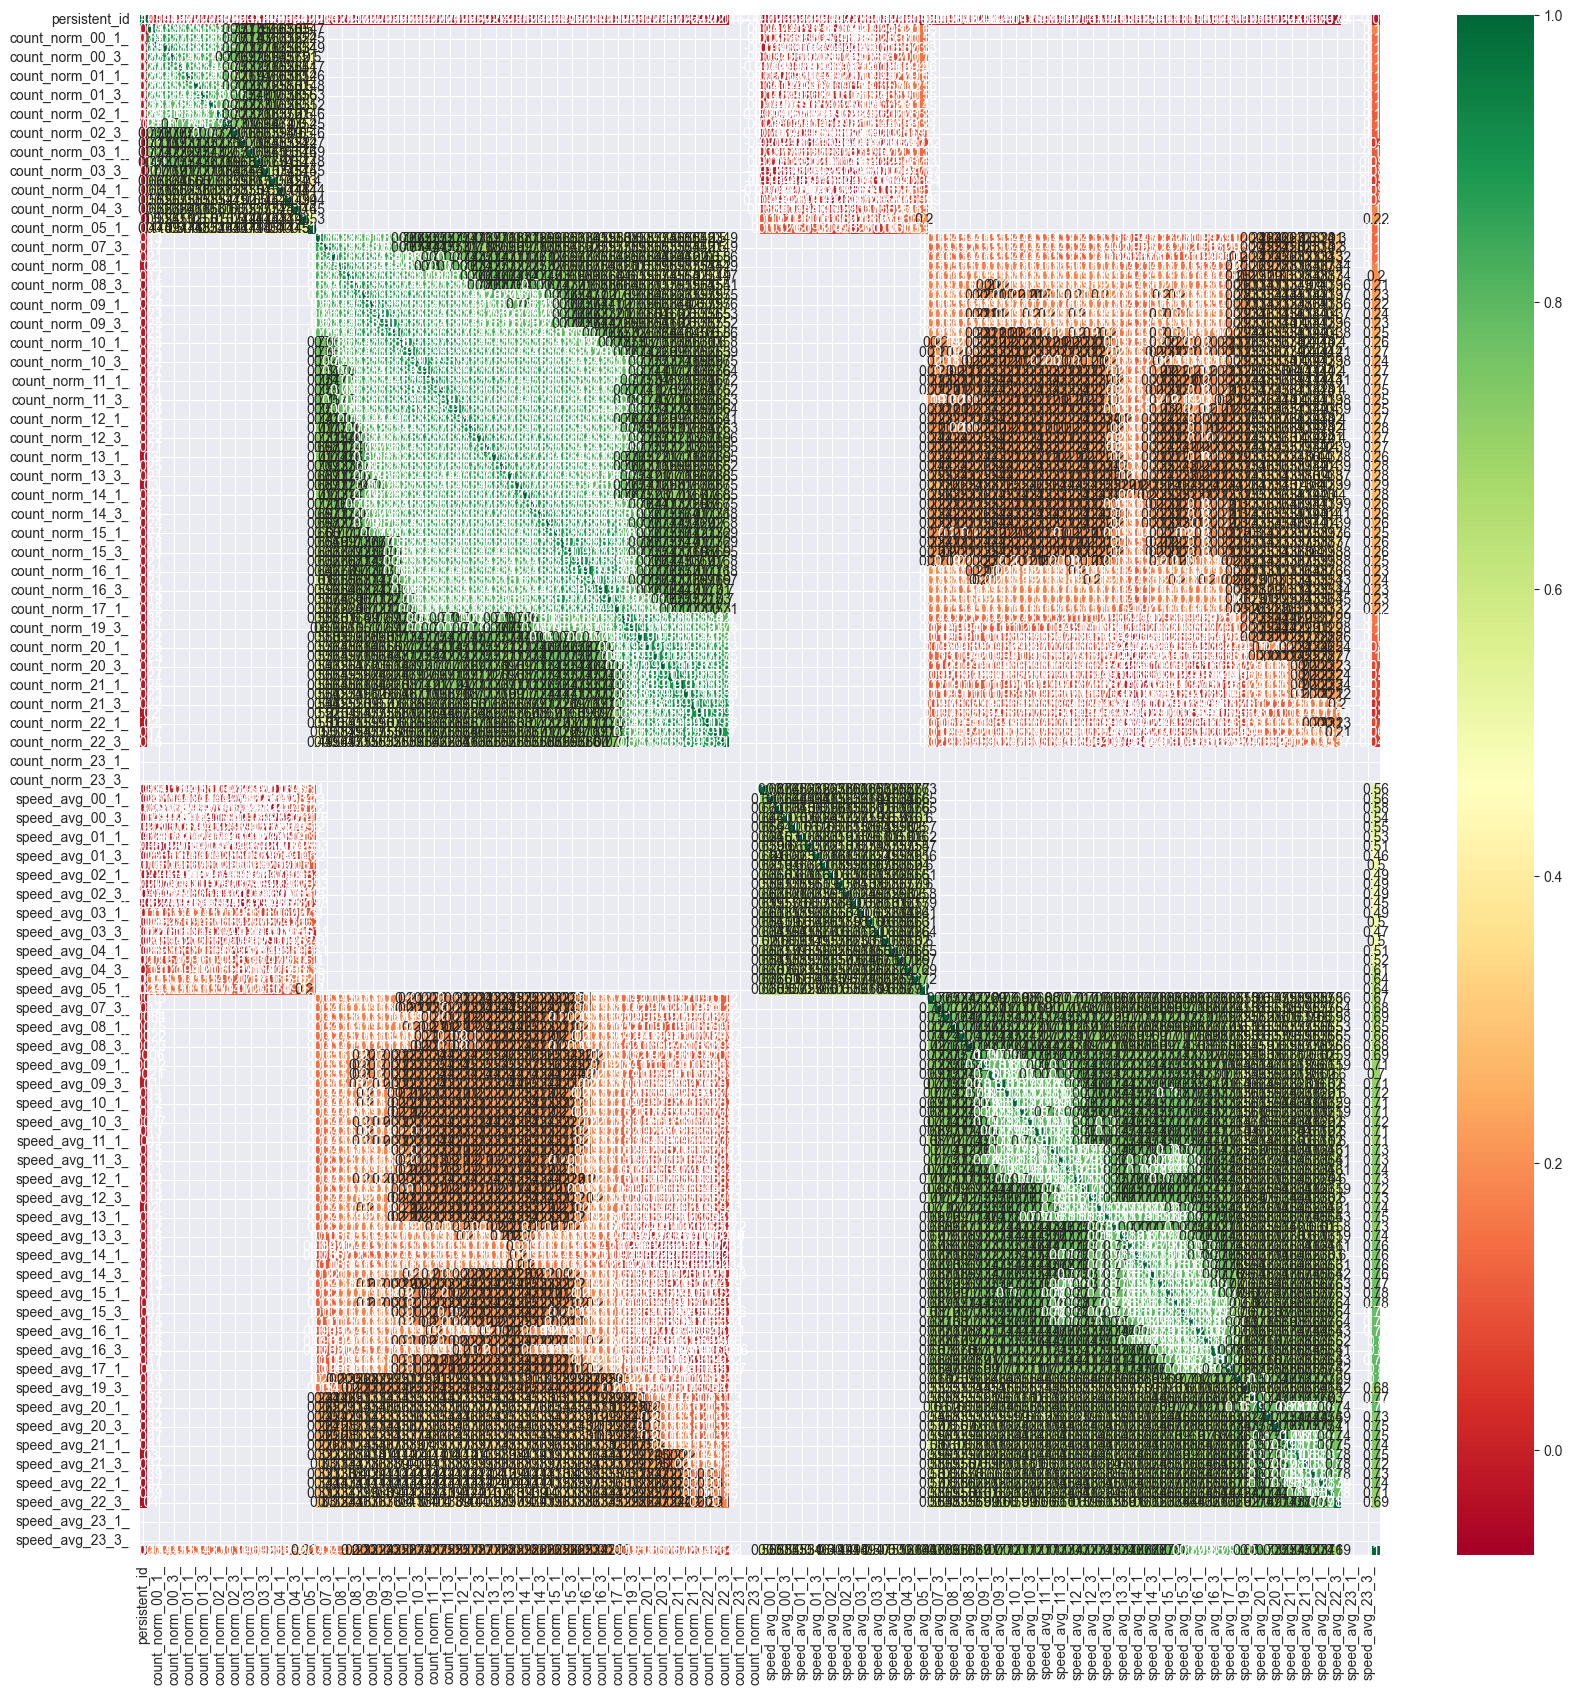

In [26]:
import seaborn as sns

# Select only numerical features
train_num_df = train.select_dtypes(include=['number'])

#get correlations of each features in dataset
corrmat = train_num_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(train_num_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [27]:
# The following function selects highly correlated features from the dataset.
# It identifies and removes the first feature that is correlated with any other feature beyond a specified threshold.

def correlation(dataset, threshold):
    col_corr = set()  # Set to store names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:  # Check for absolute correlation coefficient
                colname = corr_matrix.columns[i]  # Get the name of the correlated column
                col_corr.add(colname)
    return col_corr

# Applying the correlation function to the training dataset to identify features with correlation higher than 0.9
corr_features = correlation(X_train, 0.9)

# Output the number of correlated features identified
len(set(corr_features))

# Display the set of correlated features
corr_features


{'count_norm_00_1_',
 'count_norm_00_2_',
 'count_norm_00_3_',
 'count_norm_08_0_',
 'count_norm_08_1_',
 'count_norm_08_2_',
 'count_norm_08_3_',
 'count_norm_09_0_',
 'count_norm_09_1_',
 'count_norm_09_2_',
 'count_norm_09_3_',
 'count_norm_10_0_',
 'count_norm_10_1_',
 'count_norm_10_2_',
 'count_norm_10_3_',
 'count_norm_11_0_',
 'count_norm_11_1_',
 'count_norm_11_2_',
 'count_norm_11_3_',
 'count_norm_12_0_',
 'count_norm_12_1_',
 'count_norm_12_2_',
 'count_norm_12_3_',
 'count_norm_13_0_',
 'count_norm_13_1_',
 'count_norm_13_2_',
 'count_norm_13_3_',
 'count_norm_14_0_',
 'count_norm_14_1_',
 'count_norm_14_2_',
 'count_norm_14_3_',
 'count_norm_15_0_',
 'count_norm_15_1_',
 'count_norm_15_2_',
 'count_norm_15_3_',
 'count_norm_16_0_',
 'count_norm_16_1_',
 'count_norm_16_2_',
 'count_norm_16_3_',
 'count_norm_17_0_',
 'count_norm_17_1_',
 'count_norm_19_3_',
 'count_norm_20_0_',
 'count_norm_20_1_',
 'count_norm_20_2_',
 'count_norm_20_3_',
 'count_norm_21_0_',
 'count_norm_

In [28]:
# List of most correlated features names in the dataset, including the target variable
df = ['count_norm_00_1_', 'count_norm_00_2_', 'count_norm_00_3_', 'count_norm_08_0_', 
      'count_norm_08_1_', 'count_norm_08_2_', 'count_norm_08_3_', 'count_norm_09_0_', 
      'count_norm_09_1_', 'count_norm_09_2_', 'count_norm_09_3_', 'count_norm_10_0_', 
      'count_norm_10_1_', 'count_norm_10_2_', 'count_norm_10_3_', 'count_norm_11_0_', 
      'count_norm_11_1_', 'count_norm_11_2_', 'count_norm_11_3_', 'count_norm_12_0_', 
      'count_norm_12_1_', 'count_norm_12_2_', 'count_norm_12_3_', 'count_norm_13_0_', 
      'count_norm_13_1_', 'count_norm_13_2_', 'count_norm_13_3_', 'count_norm_14_0_',
      'count_norm_14_1_', 'count_norm_14_2_', 'count_norm_14_3_', 'count_norm_15_0_', 
      'count_norm_15_1_', 'count_norm_15_2_', 'count_norm_15_3_', 'count_norm_16_0_', 
      'count_norm_16_1_', 'count_norm_16_2_', 'count_norm_16_3_', 'count_norm_17_0_', 
      'count_norm_17_1_', 'count_norm_19_3_', 'count_norm_20_0_', 'count_norm_20_1_', 
      'count_norm_20_2_', 'count_norm_20_3_', 'count_norm_21_0_', 'count_norm_21_1_', 
      'count_norm_21_2_', 'count_norm_21_3_', 'count_norm_22_0_', 'count_norm_22_1_', 
      'count_norm_22_2_', 'count_norm_22_3_', 'speed_avg_10_1_', 'speed_avg_10_2_', 
      'speed_avg_11_0_', 'speed_avg_11_1_', 'speed_avg_11_2_', 'speed_avg_11_3_', 
      'speed_avg_12_0_', 'speed_avg_12_1_', 'speed_avg_12_2_', 'speed_avg_13_0_', 
      'speed_avg_13_1_', 'speed_avg_13_3_', 'speed_avg_14_0_', 'speed_avg_14_1_', 
      'speed_avg_14_2_', 'speed_avg_14_3_', 'speed_avg_15_0_', 'speed_avg_15_1_', 
      'speed_avg_15_2_', 'speed_avg_15_3_', 'speed_avg_16_0_', 'speed_avg_16_1_', 'target']


In [29]:
# Select the features from the training dataset using the specified column names
X1 = train[df]

# Display the shape of the resulting dataframe to confirm the dimensions
X1.shape


(26157, 77)

In [30]:
# Display the first few rows of the dataframe X1 to preview the data
X1.head()


count_norm_00_1_  count_norm_00_2_  count_norm_00_3_  count_norm_08_0_  \
0               NaN           0.00004           0.00002               NaN   
1           0.00007           0.00001           0.00003               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN           0.00014   
4               NaN               NaN               NaN           0.00018   

   count_norm_08_1_  count_norm_08_2_  count_norm_08_3_  count_norm_09_0_  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2               NaN           0.00005               NaN           0.00004   
3           0.00015           0.00018           0.00017           0.00033   
4           0.00023           0.00030           0.00032           0.00013   

   count_norm_09_1_  count_norm_09_2_  count_norm_09_3_  count_norm_10_0_  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2               NaN           0.00007           0.00008           0.00010   
3           0.00040           0.00035           0.00021           0.00046   
4           0.00012           0.00017           0.00028           0.00029   

   count_norm_10_1_  count_norm_10_2_  count_norm_10_3_  count_norm_11_0_  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2           0.00007           0.00006           0.00004           0.00011   
3           0.00083           0.00043           0.00060           0.00052   
4           0.00010           0.00023           0.00036           0.00007   

   count_norm_11_1_  count_norm_11_2_  count_norm_11_3_  count_norm_12_0_  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2           0.00012           0.00013           0.00016           0.00009   
3           0.00042           0.00072           0.00041           0.00034   
4           0.00021           0.00010           0.00017           0.00028   

   count_norm_12_1_  count_norm_12_2_  count_norm_12_3_  count_norm_13_0_  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2           0.00016           0.00021           0.00015           0.00024   
3           0.00049           0.00025           0.00026           0.00052   
4           0.00013           0.00015           0.00021           0.00009   

   count_norm_13_1_  count_norm_13_2_  count_norm_13_3_  count_norm_14_0_  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2           0.00012           0.00009           0.00018           0.00012   
3           0.00038           0.00054           0.00044           0.00063   
4           0.00006           0.00005           0.00017           0.00011   

   count_norm_14_1_  count_norm_14_2_  count_norm_14_3_  count_norm_15_0_  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2           0.00004           0.00013           0.00009           0.00010   
3           0.00045           0.00050           0.00041           0.00053   
4           0.00006           0.00015           0.00008           0.00013   

   count_norm_15_1_  count_norm_15_2_  count_norm_15_3_  count_norm_16_0_  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2           0.00017           0.00009           0.00015           0.

In [31]:
# Drop the specified columns from the training dataset and fill any missing values with 0
X2 = train.drop(['ID', 'persistent_id', 'prediction_type'], axis=1).fillna(0)


In [38]:
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import KFold

# Initialize KFold with 20 splits, shuffling, and a fixed random state for reproducibility
fold = KFold(n_splits=20, shuffle=True, random_state=42)
fold_pred_2 = []
oof_pred_2 = []

# Specify the target variable column name
label = 'target'

# Iterate over each fold for training and validation
for train_index, test_index in fold.split(X2):
    X_train, X_test = X2.iloc[train_index], X2.iloc[test_index]
    
    # Convert pandas DataFrames to TensorFlow datasets for training and validation
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label=label, task=tfdf.keras.Task.REGRESSION)
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_test, label=label, task=tfdf.keras.Task.REGRESSION)
    
    # Initialize and compile the Random Forest model for regression
    rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
    rf.compile(metrics=["rmse"])
    
    # Fit the model on the training dataset
    rf.fit(x=train_ds)
    
    # Extract true target values and prepare test dataset
    y_test = X_test[label].values
    X_test = X_test.drop(columns=[label])
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_test, task=tfdf.keras.Task.REGRESSION)
    
    # Make predictions and compute RMSE
    preds = rf.predict(test_ds).squeeze()
    rmse = mean_squared_error(y_test, preds, squared=False)
    
    # Print RMSE for the current fold
    print("RMSE: ", rmse)
    oof_pred_2.append(rmse)

# Print the average RMSE across all folds
print(np.mean(oof_pred_2))


Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmp42siwdji as temporary training directory
Reading training dataset...
Training dataset read in 0:00:05.260448. Found 24849 examples.
Training model...


[INFO 24-08-12 19:55:43.8787 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmp42siwdji/model/ with prefix d5345532d49e4537


Model trained in 0:00:50.718681
Compiling model...


[INFO 24-08-12 19:55:46.4331 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1429688 node(s), and 153 input feature(s).
[INFO 24-08-12 19:55:46.4332 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 19:55:46.4332 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 18ms/step
rmse:  1.400499615703085
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpj2nx89ej as temporary training directory
Reading training dataset...
Training dataset read in 0:00:04.458733. Found 24849 examples.
Training model...


[INFO 24-08-12 19:56:56.2487 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpj2nx89ej/model/ with prefix aeaaf1fd547f49ec


Model trained in 0:00:57.526549
Compiling model...


[INFO 24-08-12 19:56:58.8070 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1433832 node(s), and 153 input feature(s).
[INFO 24-08-12 19:56:58.8071 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 19:56:58.8071 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 20ms/step
rmse:  1.7370072450392027
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmppegvztmk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:05.040409. Found 24849 examples.
Training model...


[INFO 24-08-12 19:58:02.3700 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmppegvztmk/model/ with prefix 75fa612261f34009


Model trained in 0:00:50.453888
Compiling model...


[INFO 24-08-12 19:58:04.9010 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1426464 node(s), and 153 input feature(s).
[INFO 24-08-12 19:58:04.9011 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 19:58:04.9011 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 18ms/step
rmse:  1.4789490217535926
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpjt63rvfx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.676002. Found 24849 examples.
Training model...


[INFO 24-08-12 19:59:06.6403 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpjt63rvfx/model/ with prefix b849a31cd239479c


Model trained in 0:00:50.494482
Compiling model...


[INFO 24-08-12 19:59:09.1911 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1430776 node(s), and 153 input feature(s).
[INFO 24-08-12 19:59:09.1911 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 19:59:09.1912 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 17ms/step
rmse:  1.4920003550164302
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpz1ay_stl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:04.002178. Found 24849 examples.
Training model...


[INFO 24-08-12 20:00:11.9750 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpz1ay_stl/model/ with prefix b6c36e42fd194bca


Model trained in 0:00:50.646463
Compiling model...


[INFO 24-08-12 20:00:14.5249 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1433508 node(s), and 153 input feature(s).
[INFO 24-08-12 20:00:14.5250 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:00:14.5250 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 18ms/step
rmse:  1.5398832877665112
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpxhdk0o0h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.451397. Found 24849 examples.
Training model...


[INFO 24-08-12 20:01:16.3367 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpxhdk0o0h/model/ with prefix c3bd59a6eaa24851


Model trained in 0:00:50.740679
Compiling model...


[INFO 24-08-12 20:01:18.9281 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1427338 node(s), and 153 input feature(s).
[INFO 24-08-12 20:01:18.9282 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:01:18.9282 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 18ms/step
rmse:  1.5170690876328825
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpl1pp2b3p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.303285. Found 24849 examples.
Training model...


[INFO 24-08-12 20:02:20.9817 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpl1pp2b3p/model/ with prefix 87e3f74fcc9443a6


Model trained in 0:00:51.061926
Compiling model...


[INFO 24-08-12 20:02:23.5382 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1427166 node(s), and 153 input feature(s).
[INFO 24-08-12 20:02:23.5382 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:02:23.5383 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 17ms/step
rmse:  1.5209138132752034
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpqwflswpo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.967593. Found 24849 examples.
Training model...


[INFO 24-08-12 20:03:25.9673 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpqwflswpo/model/ with prefix 06c5ea8a67e34b7e


Model trained in 0:00:50.884890
Compiling model...


[INFO 24-08-12 20:03:28.5246 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1425410 node(s), and 153 input feature(s).
[INFO 24-08-12 20:03:28.5247 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:03:28.5247 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 1s 18ms/step
rmse:  1.5738068992127674
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmp5zpwfyq_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.947400. Found 24849 examples.
Training model...


[INFO 24-08-12 20:04:30.5463 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmp5zpwfyq_/model/ with prefix 6b8f483d504e4b4f


Model trained in 0:00:50.896411
Compiling model...


[INFO 24-08-12 20:04:33.1282 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1437604 node(s), and 153 input feature(s).
[INFO 24-08-12 20:04:33.1282 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:04:33.1283 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 18ms/step
rmse:  1.6081753566983887
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmp8_ntm35q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.926746. Found 24849 examples.
Training model...


[INFO 24-08-12 20:05:35.3557 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmp8_ntm35q/model/ with prefix 368277f6c64e4ca7


Model trained in 0:00:50.703828
Compiling model...


[INFO 24-08-12 20:05:37.9196 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1428522 node(s), and 153 input feature(s).
[INFO 24-08-12 20:05:37.9196 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:05:37.9197 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 1s 18ms/step
rmse:  1.507043668247823
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmp4q_7mch9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.872067. Found 24849 examples.
Training model...


[INFO 24-08-12 20:06:40.4175 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmp4q_7mch9/model/ with prefix bc096d5e23374681


Model trained in 0:00:50.674677
Compiling model...


[INFO 24-08-12 20:06:42.9938 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1439252 node(s), and 153 input feature(s).
[INFO 24-08-12 20:06:42.9939 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:06:42.9939 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 18ms/step
rmse:  1.4733168801560144
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmp3pyvtb25 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.541718. Found 24849 examples.
Training model...


[INFO 24-08-12 20:07:46.4171 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmp3pyvtb25/model/ with prefix 14eb4284735e4fb6


Model trained in 0:00:51.511828
Compiling model...


[INFO 24-08-12 20:07:48.9819 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1432402 node(s), and 153 input feature(s).
[INFO 24-08-12 20:07:48.9819 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:07:48.9819 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 18ms/step
rmse:  1.538885111105525
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmp6tljr0f1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.156889. Found 24849 examples.
Training model...


[INFO 24-08-12 20:08:50.4293 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmp6tljr0f1/model/ with prefix b50e5cc875af497d


Model trained in 0:00:50.635293
Compiling model...


[INFO 24-08-12 20:08:52.9651 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1422424 node(s), and 153 input feature(s).
[INFO 24-08-12 20:08:52.9651 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:08:52.9651 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 18ms/step
rmse:  1.6069125491363816
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpm54p1260 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.408927. Found 24849 examples.
Training model...


[INFO 24-08-12 20:09:54.6312 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpm54p1260/model/ with prefix a1379948d1c44ca9


Model trained in 0:00:50.504456
Compiling model...


[INFO 24-08-12 20:09:57.1693 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1426106 node(s), and 153 input feature(s).
[INFO 24-08-12 20:09:57.1694 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:09:57.1694 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 18ms/step
rmse:  1.5302966256416195
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpq9_82gjf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.974509. Found 24849 examples.
Training model...


[INFO 24-08-12 20:10:58.1765 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpq9_82gjf/model/ with prefix 4ea65b11f3f64d7b


Model trained in 0:00:50.413639
Compiling model...


[INFO 24-08-12 20:11:00.7333 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1433104 node(s), and 153 input feature(s).
[INFO 24-08-12 20:11:00.7334 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:11:00.7335 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 18ms/step
rmse:  1.5468503430315461
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpp4q2x9f9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.171803. Found 24849 examples.
Training model...


[INFO 24-08-12 20:12:02.9300 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpp4q2x9f9/model/ with prefix c2f71b96b2134295


Model trained in 0:00:50.665792
Compiling model...


[INFO 24-08-12 20:12:05.5188 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1434174 node(s), and 153 input feature(s).
[INFO 24-08-12 20:12:05.5188 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:12:05.5189 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 18ms/step
rmse:  1.5874864395069346
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmph4dew4qg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.562549. Found 24849 examples.
Training model...


[INFO 24-08-12 20:13:08.3202 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmph4dew4qg/model/ with prefix 5f674b0b9ace4a60


Model trained in 0:00:51.489541
Compiling model...


[INFO 24-08-12 20:13:10.8819 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1432850 node(s), and 153 input feature(s).
[INFO 24-08-12 20:13:10.8820 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:13:10.8820 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 19ms/step
rmse:  1.5329418554411756
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmp_zzxgbke as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.678680. Found 24850 examples.
Training model...


[INFO 24-08-12 20:14:22.0504 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmp_zzxgbke/model/ with prefix 6c62451dcda94a78


Model trained in 0:01:00.663232
Compiling model...


[INFO 24-08-12 20:14:24.5735 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1429916 node(s), and 153 input feature(s).
[INFO 24-08-12 20:14:24.5736 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:14:24.5736 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 19ms/step
rmse:  1.529089154879894
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpl3r4zy_m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.245124. Found 24850 examples.
Training model...


[INFO 24-08-12 20:15:25.4972 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpl3r4zy_m/model/ with prefix 91930c2c86954614


Model trained in 0:00:49.952193
Compiling model...


[INFO 24-08-12 20:15:28.0678 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1427042 node(s), and 153 input feature(s).
[INFO 24-08-12 20:15:28.0679 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:15:28.0679 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 19ms/step
rmse:  1.6252306132016023
Use /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpcip8f2cd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.894001. Found 24850 examples.
Training model...


[INFO 24-08-12 20:16:30.4055 EAT kernel.cc:1233] Loading model from path /var/folders/w1/c847501n7gv4f1lx19jnx2l40000gn/T/tmpcip8f2cd/model/ with prefix 2542b7ef1d0b400d


Model trained in 0:00:50.701698
Compiling model...


[INFO 24-08-12 20:16:33.0925 EAT decision_forest.cc:660] Model loaded with 300 root(s), 1436666 node(s), and 153 input feature(s).
[INFO 24-08-12 20:16:33.0927 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-12 20:16:33.0927 EAT kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 1s 18ms/step
rmse:  1.605490844446181
1.547592438344638


* Cross-Validation Setup: 
Utilizes K-Fold cross-validation with 20 folds to ensure robust model evaluation.

* Data Preparation: 
Converts pandas DataFrames to TensorFlow datasets appropriate for the regression task.

* Model Training: 
Instantiates and trains a RandomForestRegressor using TensorFlow Decision Forests, evaluating it with Root Mean Squared Error (RMSE) as the metric.

* Performance Evaluation: 
Computes RMSE for each fold and prints the average RMSE across all folds to assess model performance.

__This approach provides a comprehensive evaluation of the model's performance, ensuring that the results are not biased by any particular data split.__



In [39]:
# Drop irrelevant columns and fill missing values with 0
t = test.drop(['ID', 'persistent_id', 'prediction_type'], axis=1).fillna(0)

# Convert the prepared DataFrame to a TensorFlow dataset for regression
nseen_data_ds = tfdf.keras.pd_dataframe_to_tf_dataset(t, task=tfdf.keras.Task.REGRESSION)

# Predict on the unseen data using the trained RandomForestRegressor model
preds00 = rf.predict(nseen_data_ds)


12/12 [==============================] - 1s 108ms/step


__Data Preparation:__ The test DataFrame is preprocessed by dropping non-predictive columns (ID, persistent_id, prediction_type) and filling any missing values with zero. This ensures that the dataset is suitable for prediction.

__Conversion to TensorFlow Dataset:__ The cleaned DataFrame (t) is converted into a TensorFlow dataset, formatted for regression tasks. This step aligns the data format with what the trained model expects for making predictions.

__Prediction:__ The trained RandomForestRegressor model (rf) is used to predict outcomes on the unseen dataset (nseen_data_ds). The predictions are stored in preds00, ready for further analysis or evaluation.

__This approach ensures that the model can be effectively applied to new data, following proper data preprocessing and conversion steps to maintain consistency with the training phase.__

In [40]:
# Flatten the predictions array to ensure it is one-dimensional
preds00 = preds00.flatten()

# Create a DataFrame to store the predictions along with the corresponding IDs
pred = pd.DataFrame({'ID': test['ID'], 'target': preds00})

# Display the first few rows of the predictions DataFrame for review
pred.head()


ID   target
0     5805365396938277294_X_lbo_weekday_X_morning_rush_hour  6.04803
1  6383912664733604267_X_second_weekday_X_evening_rush_hour  9.83775
2   9685043778615900869_X_other_holiday_X_evening_rush_hour 10.66726
3   13385092549461410612_X_last_weekday_X_morning_rush_hour 12.15355
4   5760726675439177299_X_other_weekday_X_evening_rush_hour  5.60231

__Flatten Predictions:__ The predictions array (preds00) is flattened to ensure it is a one-dimensional array. This step aligns the predictions with the expected format for further processing or saving.

__Create Predictions DataFrame:__ A new DataFrame (pred) is created to include the ID from the original test dataset and the corresponding target predictions. This DataFrame is structured to facilitate easy review and export of the results.

__Preview Results:__ The head() function is used to display the first few rows of the pred DataFrame. This allows for a quick check to ensure that the predictions are correctly aligned with the test IDs.

__This process ensures that predictions are properly formatted and reviewed before being saved or used for subsequent analysis.__

